In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from skopt import BayesSearchCV
import shap
import pickle

In [2]:
products = pd.read_csv('Products Table.csv')
orders = pd.read_csv('Orders Table.csv')

## Demand Indicators

### Monthly Sales Volume for Each Product

In [3]:
orders['Order Date'] = pd.to_datetime(orders['Order Date']) 

# number of sales for each product per month
monthly_sales_volume = orders.groupby(['ProductID', pd.Grouper(key='Order Date', freq='M')])['OrderID'].count().reset_index()
monthly_sales_volume.rename(columns={'OrderID': 'Monthly Sales Volume'}, inplace=True)

/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_18379/2658778723.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales_volume = orders.groupby(['ProductID', pd.Grouper(key='Order Date', freq='M')])['OrderID'].count().reset_index()


### Sales Trends

In [4]:
# 3-month rolling average of sales volume for each product
monthly_sales_volume['Sales Trend'] = monthly_sales_volume.groupby('ProductID')['Monthly Sales Volume'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
products = products.merge(monthly_sales_volume, on = 'ProductID', how = 'inner')

### Promotional Influence

In [5]:
# number of sales for each product when on promotion
promo_sales_volume = orders[orders['Promotional Period'] == 1].groupby('ProductID')['OrderID'].count().reset_index()
promo_sales_volume.rename(columns={'OrderID': 'Promo Sales Volume'}, inplace=True)

# number of sales for each product when not on promotion
non_promo_sales_volume = orders[orders['Promotional Period'] == 0].groupby('ProductID')['OrderID'].count().reset_index()
non_promo_sales_volume.rename(columns={'OrderID': 'Non Promo Sales Volume'}, inplace=True)

# merging
promo_influence = promo_sales_volume.merge(non_promo_sales_volume, on = 'ProductID', how = 'outer')
promo_influence = promo_influence.fillna(0) 

products = products.merge(promo_influence, on = 'ProductID', how = 'inner')

## Competitor Pricing

In [6]:
products['Competitor Price'] = round(products['Price'] * np.random.uniform(0.7, 1.3, size = len(products)), 2)
products['Price Comparison Index'] = products['Price']/products['Competitor Price'] # ratio of own price to competitor's price

## Inventory Levels

### Stock Levels

In [7]:
products['Stock Level'] = np.random.randint(0, 100, size = len(products))

### Restock Frequency

In [8]:
products['Restock Frequency'] = np.random.choice([10, 20, 30], len(products))

## Dynamic Pricing Model

### Preparing our features

In [9]:
df = products[['Category', 'Monthly Sales Volume', 'Sales Trend', 'Promo Sales Volume', 'Non Promo Sales Volume', 'Price Comparison Index', 'Stock Level', 'Restock Frequency', 'Price']]
df.drop_duplicates(inplace=True)

# removing extreme values for prices
# we choose the threshold to be the any prices below 95th percentile and above 5th percentile
df = df[(df['Price'] >= df['Price'].quantile(0.05)) & (df['Price'] <= df['Price'].quantile(0.95))]

/var/folders/ds/x32_jrs12jv6kcrbpc456sh80000gn/T/ipykernel_18379/502136623.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


### Train Test Split

In [10]:
X = df.drop('Price', axis = 1)
X = pd.get_dummies(X, columns=['Category'], drop_first=True)
y = df[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# converting boolean to binary for SHAP later on
X_train['Category_Electronics'] = X_train['Category_Electronics'].astype(int)
X_train['Category_Home Appliances'] = X_train['Category_Home Appliances'].astype(int)
X_test['Category_Electronics'] = X_test['Category_Electronics'].astype(int)
X_test['Category_Home Appliances'] = X_test['Category_Home Appliances'].astype(int)

### Choosing Best Models

In [11]:
models = {
    'XGBRegressor': XGBRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
}

param_grids = {
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9]
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9]
    },
    'LinearRegression': {}, 
}

rmse_scores = {}

for model_name, model in models.items():
    if param_grids.get(model_name):
            BayesSearch = BayesSearchCV(
            estimator=model,
            search_spaces=param_grids[model_name],
            n_iter=20,
            scoring='neg_root_mean_squared_error',
            cv=4,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
            # fitting BayesSearch
            BayesSearch.fit(X_train, y_train)
            best_model = BayesSearch.best_estimator_
            print(f"Best parameters for {model_name}: {BayesSearch.best_params_}")
    else:
        # for linear regression (no parameters to tune)
        best_model = model
        best_model.fit(X_train, y_train)
    
    # making predictions based on chosen model
    y_pred = best_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_scores[model_name] = rmse
    print(f'{model_name} RMSE: {rmse}')

best_model_name = min(rmse_scores, key=rmse_scores.get)
print(f'\nBest Model: {best_model_name} with RMSE of {rmse_scores[best_model_name]}')

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Best parameters for RandomForestRegressor: OrderedDict([('max_depth', 10), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 300)])
RandomForestRegressor RMSE: 11.151264017540552
Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Librar

Best parameters for GradientBoostingRegressor: OrderedDict([('learning_rate', 0.1), ('max_depth', 5), ('n_estimators', 300), ('subsample', 0.9)])
GradientBoostingRegressor RMSE: 11.035566039300418
LinearRegression RMSE: 11.214580419983005

Best Model: GradientBoostingRegressor with RMSE of 11.035566039300418


### Best Model

In [12]:
model = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9, random_state=42)
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(max_depth=5, n_estimators=300, random_state=42,
                          subsample=0.9)

### Feature Importance

Text(0.5, 1.0, 'Feature Importance from GradientBoostingRegressor')

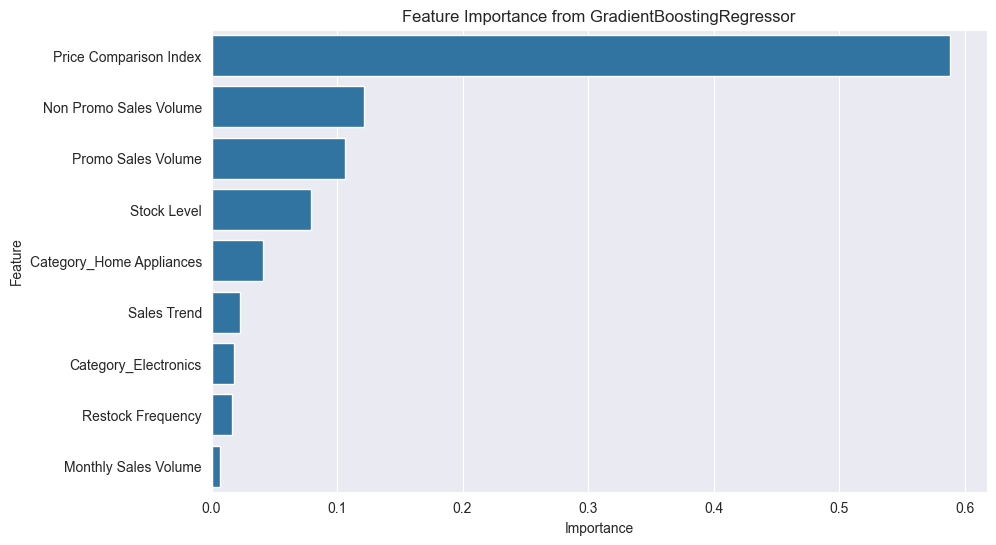

In [13]:
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance from GradientBoostingRegressor")

### SHAP

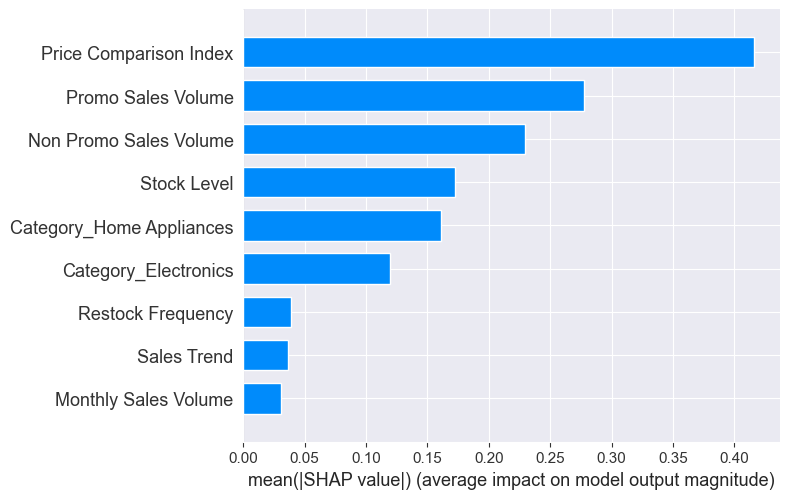

In [14]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

sns.set_style('darkgrid')
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Saving Trained Model

In [15]:
with open('PricingModel.pkl', 'wb') as file:
    pickle.dump(model, file)